In [7]:
import umap
import pandas as pd
import numpy as np
import random
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [8]:
bed_df = pd.read_csv('./data/pre-train/510/rna_selection.bed',
            sep='\t',names = ['Chr','Start','End','Gene','Label','Strand'])

In [9]:
bed_df['Label'].unique()

array(['intron,exon', 'exon', 'exon,intron', 'intron', 'intron,exon,UTR',
       'exon,UTR', 'exon,UTR,intron', 'UTR,intron,exon', 'UTR,exon',
       'intron,UTR,exon', 'UTR,exon,intron', 'intron,UTR',
       'exon,intron,UTR'], dtype=object)

In [10]:
file = open('/home/amber/multitask_RNA/data/pre-train/510/rna_seq.fa')
seq_list = file.readlines()
#label_set = bed_df['Label'].unique()
label_set = ['exon','intron']
mixed_seq = []
label = np.empty(500*len(label_set),dtype=np.dtype('U6'))
l_i = 0
for type in label_set:
    type_idx = bed_df.index[bed_df['Label']== type].tolist()
    rand_samp = random.sample(type_idx,500)
    selected_seq = [seq_list[(i)*2+1].strip().upper() for i in rand_samp]
    mixed_seq.extend(selected_seq)
    label[500*l_i:500*l_i+(500)]=type
    l_i += 1

## GPN pre-trained prediction cluster

In [5]:
import gpn.mlm
import torch
from tqdm import tqdm
from transformers import AutoModel,AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
model = AutoModel.from_pretrained("gonzalobenegas/gpn-arabidopsis").to('cuda')
tokenizer = AutoTokenizer.from_pretrained("gonzalobenegas/gpn-arabidopsis")
model.eval();

Some weights of the model checkpoint at gonzalobenegas/gpn-arabidopsis were not used when initializing ConvNetModel: ['cls.decoder.3.weight', 'cls.decoder.0.weight', 'cls.decoder.0.bias', 'cls.decoder.2.bias', 'cls.decoder.3.bias', 'cls.decoder.2.weight']
- This IS expected if you are initializing ConvNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ConvNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
model_output = []
token_seq = tokenizer.batch_encode_plus(mixed_seq,max_length=507)
for seq_i in tqdm(range(0,len(token_seq['input_ids']),5)):
        seq_batch = torch.tensor(token_seq['input_ids'][seq_i:seq_i+5]).to('cuda')
        output_seq = model(seq_batch).last_hidden_state.cpu().detach().numpy()
        model_output.extend(output_seq)
        
model_output=np.array(model_output)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
100%|██████████| 200/200 [00:06<00:00, 32.15it/s]


In [7]:
model(seq_batch).last_hidden_state.shape

torch.Size([5, 507, 512])

In [8]:
#umap_array = model_output.reshape(*model_output.shape[:-2], -1)
umap_array=np.sum(model_output,axis = 1)
reducer = umap.UMAP()
embedding = reducer.fit_transform(umap_array)

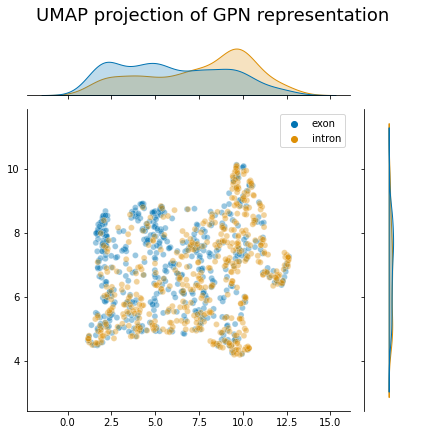

In [9]:
scatter = sns.jointplot(x = embedding[:, 0],y=embedding[:, 1],
        hue=label,palette='colorblind',alpha=0.4)
plt.gca().set_aspect('equal', 'datalim')
plt.suptitle('UMAP projection of GPN representation', fontsize=18,y = 1.0)
plt.tight_layout()

## DNA_bert_6 prediction and cluster

In [10]:
from transformers import AutoTokenizer,AutoModelForMaskedLM
import os
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
tokenizer = AutoTokenizer.from_pretrained("armheb/DNA_bert_6")
model = AutoModelForMaskedLM.from_pretrained("armheb/DNA_bert_6",output_hidden_states=True).to('cuda')

In [11]:
split_seq = []
model_output = []

for seq in mixed_seq:
    split_seq.append(' '.join([seq[i:i+6] for i in range(0, len(seq)-6+1, 1)]))
token_seq = tokenizer.batch_encode_plus(split_seq,max_length=507)
for seq_i in tqdm(range(0,len(token_seq['input_ids']),5)):
        seq_batch = torch.tensor(token_seq['input_ids'][seq_i:seq_i+5]).to('cuda')
        output_seq = model(seq_batch)[-1][-1].cpu().detach().numpy()
        model_output.extend(output_seq)
        
model_output=np.array(model_output)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
100%|██████████| 200/200 [00:10<00:00, 19.30it/s]


In [12]:
model_output.shape

(1000, 507, 768)

In [13]:
#umap_array = model_output.reshape(*model_output.shape[:-2], -1)
umap_array=np.mean(model_output,axis = 1)
reducer = umap.UMAP()
embedding = reducer.fit_transform(umap_array)

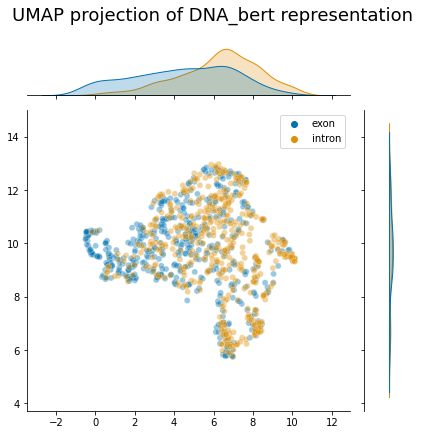

In [14]:
scatter = sns.jointplot(x = embedding[:, 0],y=embedding[:, 1],
        hue=label,palette='colorblind',alpha=0.4)
plt.gca().set_aspect('equal', 'datalim')
plt.suptitle('UMAP projection of DNA_bert representation', fontsize=18,y = 1.0)
plt.tight_layout()

## CARP Prediction and Cluster

In [18]:
import torch
from sequence_models.constants import SPECIALS
from sequence_models.collaters import SimpleCollater
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
sys.path.append('/home/amber/multitask_RNA/rna_self_train/')
import rna_model
os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device("cuda")


In [19]:
RNA='ACGTN'
RNA_ALPHABET = RNA+SPECIALS
collater = SimpleCollater(RNA_ALPHABET,False,False)
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.extend(module_out.cpu().detach().numpy())
        
    def clear(self):
        self.outputs = []

In [20]:
config={'model':'ByteNetLM',
                'lr':1e-3,
                'n_tokens':len(RNA_ALPHABET),
                'd_embedding' : 9, # dimension of embedding
                'd_model': 320, # dimension to use within ByteNet model, //2 every layer
                'n_layers' : 15, # number of layers of ByteNet block
                'activation': 'relu',
                'kernel_size' : 5, # the kernel width
                'r' : 32, # used to calculate dilation factor
                'padding_idx' : RNA_ALPHABET.index('-') ,# location of padding token in ordered alphabet
                'dropout' : 0.1 ,
                }

model = rna_model.ByteNetLM(config['n_tokens'], config['d_embedding'], config['d_model'],
                        config['n_layers'], config['kernel_size'], config['r'], config['lr'],
                        padding_idx=config['padding_idx'], causal=False, dropout=config['dropout'])
model.load_state_dict(torch.load('/home/amber/multitask_RNA/rna_self_train/rna-selftrain/2hkapjgg/checkpoints/best_model.ckpt')['state_dict'])
model.to(device)
model.eval()

ByteNetLM(
  (embedder): ByteNet(
    (embedder): Embedding(9, 9, padding_idx=6)
    (up_embedder): PositionFeedForward(
      (conv): Conv1d(9, 320, kernel_size=(1,), stride=(1,))
    )
    (layers): ModuleList(
      (0): ByteNetBlock(
        (conv): MaskedConv1d(160, 160, kernel_size=(5,), stride=(1,), padding=(2,))
        (sequence1): Sequential(
          (0): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          (1): ReLU()
          (2): PositionFeedForward(
            (conv): Conv1d(320, 160, kernel_size=(1,), stride=(1,))
          )
          (3): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          (4): ReLU()
        )
        (sequence2): Sequential(
          (0): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          (1): ReLU()
          (2): PositionFeedForward(
            (conv): Conv1d(160, 320, kernel_size=(1,), stride=(1,))
          )
        )
      )
      (1): ByteNetBlock(
        (conv): MaskedConv1d(160, 160, kernel_size=(5,

In [21]:
save_output = SaveOutput()
hook_handles = []
handle = model.last_norm.register_forward_hook(save_output)

In [22]:
expand_seq = np.expand_dims(np.array(mixed_seq),axis = -1)
token_output = collater(expand_seq)[0]
for seq_i in tqdm(range(0,len(token_output),30)):
    seq_batch = torch.tensor(token_output[seq_i:seq_i+30]).to(device)
    output_seq = model(seq_batch).cpu().detach().numpy()

  0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_391286/1633952438.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq_batch = torch.tensor(token_output[seq_i:seq_i+30]).to(device)
100%|██████████| 34/34 [00:01<00:00, 23.75it/s]


In [23]:
embed = np.array(save_output.outputs)
# embed_30 = []
# for l_seq in embed:
#     s_seq = np.split(l_seq,30)
#     embed_30.extend(s_seq)
# embed_30 = np.array(embed_30)
#umap_array = embed.reshape(*embed.shape[:-2], -1)
# umap_array=np.mean(embed_30,axis = 1)
umap_array = np.mean(embed,axis = 1)
reducer = umap.UMAP()
embedding = reducer.fit_transform(umap_array)

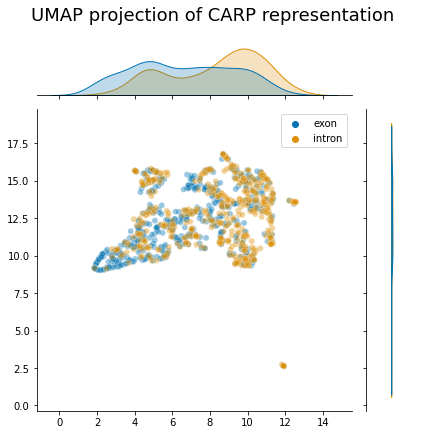

In [24]:
scatter = sns.jointplot(x = embedding[:, 0],y=embedding[:, 1],
        hue=label,palette='colorblind',alpha=0.4)
plt.gca().set_aspect('equal', 'datalim')
plt.suptitle('UMAP projection of CARP representation', fontsize=18,y = 1.0)
plt.tight_layout()


## Roberta Prediction and Cluster

In [11]:
from transformers import RobertaForMaskedLM
from tqdm import tqdm
import torch
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('/home/amber/multitask_RNA/DNA_BERT_rep/')
from dna_tokenizer import DNATokenizer

In [12]:
model = RobertaForMaskedLM.from_pretrained('/home/amber/multitask_RNA/DNA_BERT_rep/small-roberta-lr8/checkpoint-23500/',
                            output_hidden_states=True).to('cuda')
tokenizer = DNATokenizer('/home/amber/multitask_RNA/DNA_BERT_rep/vocab.txt')

In [13]:
split_seq = []
model_output = []

for seq in mixed_seq:
    split_seq.append(' '.join([seq[i:i+6] for i in range(0, len(seq)-6+1, 1)]))
token_seq = tokenizer.batch_encode_plus(split_seq,max_length=507)

In [14]:
for seq_i in tqdm(range(0,len(token_seq['input_ids']),30)):
        seq_batch = torch.tensor(token_seq['input_ids'][seq_i:seq_i+30]).to('cuda')
        output_seq = model(seq_batch)[-1][-1].cpu().detach().numpy()
        model_output.extend(output_seq)
        
model_output=np.array(model_output)

100%|██████████| 34/34 [00:05<00:00,  6.77it/s]


In [15]:
model_output.shape

(1000, 505, 120)

In [16]:
#umap_array = model_output.reshape(*model_output.shape[:-2], -1)
umap_array=np.mean(model_output,axis = 1)
reducer = umap.UMAP()
embedding = reducer.fit_transform(umap_array)

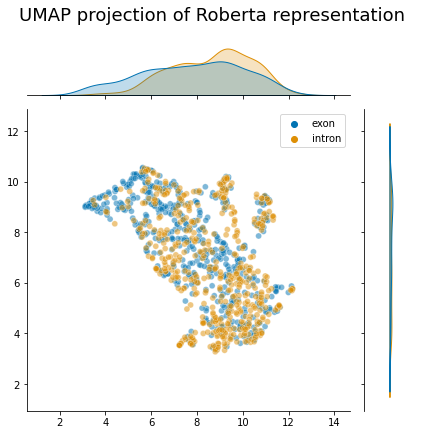

In [17]:
scatter = sns.jointplot(x = embedding[:, 0],y=embedding[:, 1],
        hue=label,palette='colorblind',alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.suptitle('UMAP projection of Roberta representation', fontsize=18,y = 1.0)
plt.tight_layout()